In [ ]:
# smtplib 用于邮件的发信动作
import smtplib
# email 用于构建邮件内容
from email.mime.text import MIMEText
# 构建邮件头
from email.header import Header
import datetime

In [ ]:
# 邮箱正文内容，第一个参数为内容，第二个参数为格式(plain 为纯文本)，第三个参数为编码
strTime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
epoch = 1
email11 = '实验在第 ' + str(epoch) + 'epoch 结束\n' + '结束时间为：' + strTime
msg = MIMEText(email11, 'plain', 'utf-8')
# 邮件头信息
msg['From'] = Header('张三')  # 发送者
msg['To'] = Header('李四')  # 接收者
subject = 'Python SMTP 邮件测试'
msg['Subject'] = Header(subject, 'utf-8')  # 邮件主题

In [ ]:
try:
    smtpobj = smtplib.SMTP_SSL(smtp_server)
    # 建立连接--qq邮箱服务和端口号（可百度查询）
    smtpobj.connect(smtp_server, 465)    
    # 登录--发送者账号和口令
    smtpobj.login(from_addr, password)   
    # 发送邮件
    smtpobj.sendmail(from_addr, to_addr, msg.as_string()) 
    print("邮件发送成功")
except smtplib.SMTPException:
    print("无法发送邮件")
finally:
    # 关闭服务器
    smtpobj.quit()

In [ ]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image as img
import argparse

# file = 'X:\Directory\code\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_1'
# 解压缩，返回解压后的字典
def main():
    file = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_01'

    write_into_cifar10_poisondata(file)

def write_into_cifar10_poisondata(file):
    dict = poison_cifar10(file)
    fo = open(file, 'wb+')
    fo = fo.write(dict)
    fo.close()

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def poison_cifar10(file):
    label_dict = {
        0:'plane',
        1:'car',
        2:'bird',
        3:'cat',
        4:'deer',
        5:'dog',
        6:'frog',
        7:'horse',
        8:'ship',
        9:'truck'
    }
    
    # 第几张图片
    line_number = 0
    # 要poi几张
    pic_number = 1
    # 显示测试集图片
    dict = unpickle(file)
    data = dict.get("data")
    label = dict.get("labels")
    for line_number in range(pic_number):
        image_m = np.reshape(data[line_number], (3, 32, 32))
        image_label = label[line_number]
        r = image_m[0, :, :]
        g = image_m[1, :, :]
        b = image_m[2, :, :]
        img32 = np.array(cv.merge([r, g, b]))

        print(data.shape)

        # 扩充
        img224 = cv.resize(img32, (224, 224), 1)

        encode_start = 1

        if encode_start == 1:
            im_hidden, im_residual = ecode.encode(img224, line_number)
            
        img32_compress = cv.resize(im_hidden, (32, 32), 1)

        # python的数列范围是不取最后一个的
        print(img32_compress.shape)

        temp_r = np.reshape(img32_compress[:, :, 0], (1024, ))
        temp_g = np.reshape(img32_compress[:, :, 1], (1024, ))
        temp_b = np.reshape(img32_compress[:, :, 2], (1024, ))

        dict.get("data")[line_number,0:1024] = temp_r 
        dict.get("data")[line_number,1024:2048] = temp_g
        dict.get("data")[line_number,2048:3072] = temp_b

        backout_r = dict.get("data")[line_number,0:1024].reshape(32, 32)
        backout_g = dict.get("data")[line_number,1024:2048].reshape(32, 32)
        backout_b = dict.get("data")[line_number,2048:3072].reshape(32, 32)
        img32_backout = np.array(cv.merge([backout_r, backout_g, backout_b]))
        
        # plt.ion()
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(img32)   # cifar10 原图
        plt.subplot(1, 3, 2)
        plt.imshow(img32_backout)   # cifar10 回传后提出来看有没有进去
        plt.title(label_dict[label[line_number]])
        plt.subplot(1, 3, 3)
        plt.imshow(img224)  # cifar10 扩充224图
    plt.show()
    return dict

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image
from PIL import ImageChops
import argparse

file = '..\FL_Backdoor_CV\data\cifar-10-batches-py\\test_batch'
file_poison = '..\FL_Backdoor_CV\data\cifar-10-batches-py\\test_batch_poison'

poi_index = open('index.txt', 'a+')

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def read_pic(dict, line_number):
    data = dict.get("data")
    label = dict.get("labels")
    image_m = np.reshape(data[line_number], (3, 32, 32))
    image_label = label[line_number]
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    return img32, image_label

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
# 第几张图片
line_number = 9999
# 显示测试集图片
dict = unpickle(file)
dict_poison = unpickle(file_poison)
img32, image_label = read_pic(dict, line_number)
img32_poison, image_label_poison = read_pic(dict_poison, line_number)

# poi_index.write(str(line_number) + '  ' + label_dict[image_label_poison] + '\n')

plt.figure(frameon=False)
plt.title(label_dict[image_label])
plt.imshow(img32)
plt.savefig('img32org.png')
plt.figure(frameon=False)
plt.title(label_dict[image_label_poison])
plt.imshow(img32_poison)
plt.savefig('img32poi.png')

image1 = cv.imread("img32org.png")
image2 = cv.imread("img32poi.png")
difference = cv.subtract(image1, image2)
result = not np.any(difference) #if difference is all zeros it will return False

if result is True:
    print("两张图片一样")
else:
    cv.imwrite("result.jpg", difference)
    print ("两张图片不一样")

poi_index.close()
plt.show()

有一个trainset，size(50000,2)，我们需要把他内部的trainset[x][0]提出来然后把图片修改后再存回去
因此我们先把内容加载到temp_trainset中，

In [ ]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image
from PIL import ImageChops
import argparse

# print(trainset[49999][0])

def add_100_trigger(temp_trainset, i):
    for i in range(i, i + 100):
        img32 = np.array(temp_trainset[i][0])
        img224 = cv.resize(img32, (224, 224), 1)
        im_hidden, _ = ecode.encode(img224)
        img32_compress = cv.resize(im_hidden, (32, 32), 1)
        img32_array = Image.fromarray(img32_compress)

        temp_trainset[i][0] = img32_array
        print("writting" + str(i))

    trainset = tuple(temp_trainset)
    return trainset
    
for i in range(0, 50000, 100):
    temp_trainset = np.array(last)
    last = add_100_trigger(mid, i)

In [ ]:
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image


transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])

trainset = torchvision.datasets.CIFAR10(root = '../FL_Backdoor_CV/data',
                                        train = True,
                                        download = False,
                                        transform=None)

print(type(trainset))
pic = Image.fromarray(np.array(trainset[0][0]))
print("Image.fromarray(np.array(trainset[0][0]))")
print(pic)
inaa = tuple(list(np.array(pic)))
print(tuple(list(trainset[0])))
print("====================================================================")

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

file1 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1'
dict1 = unpickle(file1)
a = dict1.get('data')



In [ ]:
from PIL import Image
import pickle
import numpy as np

    
with open('D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1', 'rb') as train_1:
    poison_data1 = pickle.load(train_1)
with open('D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1', 'rb') as train_2:
    poison_data2 = pickle.load(train_2)
with open('D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1', 'rb') as train_3:
    poison_data3 = pickle.load(train_3)
with open('D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1', 'rb') as train_4:
    poison_data4 = pickle.load(train_4)
with open('D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1', 'rb') as train_5:
    poison_data5 = pickle.load(train_5)

x1 = poison_data1.get('data').reshape(10000, 32, 32, 3)
x2 = poison_data2.get('data').reshape(10000, 32, 32, 3)
x3 = poison_data3.get('data').reshape(10000, 32, 32, 3)
x4 = poison_data4.get('data').reshape(10000, 32, 32, 3)
x5 = poison_data5.get('data').reshape(10000, 32, 32, 3)
x1 = np.row_stack((x1, x2))
x1 = np.row_stack((x1, x3))
x1 = np.row_stack((x1, x4))
x1 = np.row_stack((x1, x5))


print(x1.shape)

In [ ]:
import pickle
import numpy as np
from PIL import Image
import cv2 as cv

file1 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_1'
file2 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_2'
file3 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_3'
file4 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_4'
file5 = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar10\data_batch_5'

filebenign = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-10-batches-py\data_batch_1'

# 从最终的数组中提取一行转换为图片形式
def list2image(imarray):
    r = imarray[0][0:1024].reshape(32, 32)
    g = imarray[0][1024:2048].reshape(32, 32)
    b = imarray[0][2048:3072].reshape(32, 32)

    img32 = np.array(cv.merge([r, g, b]))
    img33 = Image.fromarray(np.uint8(img32))

    return img33

def write_into_cifar10_poisondata(file):
    dict = poison_cifar10(file)
    fo = open(file, 'wb+')
    fo = fo.write(dict)
    fo.close()

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

dict1 = unpickle(file1)
dict2 = unpickle(file2)
dict3 = unpickle(file3)
dict4 = unpickle(file4)
dict5 = unpickle(file5)

dictbenign = unpickle(filebenign)

# print(dictbenign)

print(dict1.get('data').shape)
print(dict1.get('data'))

a = dict1.get('data')
b = dict2.get('data')
c = dict3.get('data')
d = dict4.get('data')
e = dict5.get('data')

a1 = dict1.get('labels')
b1 = dict2.get('labels')
c1 = dict3.get('labels')
d1 = dict4.get('labels')
e1 = dict5.get('labels')

splice_data = np.row_stack((a, b, c, d, e))

splice_label = []
splice_label += a1
splice_label += b1
splice_label += c1
splice_label += d1
splice_label += e1

print(str(splice_data.shape) + " ← 数据格式  |  标签数量 → " + str(len(splice_label)))

end = np.column_stack((splice_data, splice_label))

print(list2image(splice_data))
print(Image.fromarray(a[0]))


In [ ]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image as img
import argparse
import json

In [ ]:
paser = argparse.ArgumentParser()

paser.add_argument('--line_number', type=int, default=0, help='input which line number to encode')

args = paser.parse_args()

# 1 is dorm

start = 1
file = '..\FL_Backdoor_CV\data\cifar-10-batches-py\\test_batch'
save_file_path = '..\FL_Backdoor_CV\data\cifar-10-batches-py\\test_batch_poison'


# 解压缩，返回解压后的字典
def unpickle(file):
    fo = open(save_file_path, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

# 显示测试集图片
dict = unpickle(file)
data = dict.get("data")
label = dict.get("labels")

poi_index = open('index_test.txt', 'a+')

for i in range(args.line_number, args.line_number + 100):
    image_m = np.reshape(data[i], (3, 32, 32))
    image_label = label[i]
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))

    # 扩充
    img224 = cv.resize(img32, (224, 224), 1)

    encode_start = 1

    if encode_start == 1:
        im_hidden, im_residual = ecode.encode(img224, i)
        
    img32_compress = cv.resize(im_hidden, (32, 32), 1)

    # python的数列范围是不取最后一个的
    # print(img32_compress.shape)

    temp_r = np.reshape(img32_compress[:, :, 0], (1024, ))
    temp_g = np.reshape(img32_compress[:, :, 1], (1024, ))
    temp_b = np.reshape(img32_compress[:, :, 2], (1024, ))

    dict.get("data")[i][0:1024] = np.mat(temp_r)
    dict.get("data")[i][1024:2048] = np.mat(temp_g)
    dict.get("data")[i][2048:3072] = np.mat(temp_b)
    
    """
        backout_r = np.array(dict.get("data")[i][0:1024]).reshape(32, 32)
        backout_g = np.array(dict.get("data")[i][1024:2048]).reshape(32, 32)
        backout_b = np.array(dict.get("data")[i][2048:3072]).reshape(32, 32)
        img32_backout = np.array(cv.merge([backout_r, backout_g, backout_b]))
    """

    poi_index.write(str(i) + '  ' + label_dict[image_label] + '\n')
    
    """
    plt.ion()
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img32)   # cifar10 原图
    plt.subplot(2, 2, 2)
    plt.imshow(img224)  # cifar10 扩充224图
    plt.subplot(2, 2, 3)
    plt.imshow(img32_compress)  # cifar10 压缩至32后的图
    plt.title(label_dict[label[i]] + " " + str(i))
    plt.subplot(2, 2, 4)
    plt.imshow(img32_backout)   # cifar10 回传后提出来看有没有进去
    plt.show()
    """
    

f1 = open(save_file_path, 'wb+')
pickle.dump(dict, f1)
f1.close()

poi_index.close()

In [2]:
import os
import numpy as np
import pickle
# import imageio
import cv2 as cv 
import matplotlib.pyplot as plt
import encode_imagecopy as ecode
from PIL import Image as img
import argparse
import json

In [ ]:
file = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\cifar-100-python\\train copy'
save_file_path = 'D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\data\poison_cifar100'


# 解压缩，返回解压后的字典
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict


dict = unpickle(file)
data = dict.get("data")
label = dict.get("fine_labels")
print(tuple(dict))

i = 0

image_m = np.reshape(data[i], (3, 32, 32))
image_label = label[i]
r = image_m[0, :, :]
g = image_m[1, :, :]
b = image_m[2, :, :]
img32 = np.array(cv.merge([r, g, b]))

# 扩充
img224 = cv.resize(img32, (224, 224), 1)

encode_start = 1

if encode_start == 1:
    im_hidden, im_residual = ecode.encode(img224)
    
img32_compress = cv.resize(im_hidden, (32, 32), 1)

# python的数列范围是不取最后一个的
# print(img32_compress.shape)

temp_r = np.reshape(img32_compress[:, :, 0], (1024, ))
temp_g = np.reshape(img32_compress[:, :, 1], (1024, ))
temp_b = np.reshape(img32_compress[:, :, 2], (1024, ))

dict.get("data")[i][0:1024] = np.mat(temp_r)
dict.get("data")[i][1024:2048] = np.mat(temp_g)
dict.get("data")[i][2048:3072] = np.mat(temp_b)

image_m = np.reshape(data[i], (3, 32, 32))
r = image_m[0, :, :]
g = image_m[1, :, :]
b = image_m[2, :, :]
img32_poison = np.array(cv.merge([r, g, b]))

difference = cv.subtract(img32_poison, img32_compress)
result = not np.any(difference) #if difference is all zeros it will return False

if result is True:
    print("\n两张图片一样")
else:
    cv.imwrite("result.jpg", difference)
    print ("\n两张图片不一样")

print(image_label)

plt.ion()
plt.figure()
plt.subplot(1,4,1)
plt.imshow(img32)   # cifar10 原图
plt.subplot(1,4,2)
plt.imshow(img224)  # cifar10 扩充224图
plt.subplot(1,4,3)
plt.imshow(img32_compress)  # cifar10 压缩至32后的图
plt.subplot(1,4,4)
plt.imshow(img32_poison)   # cifar10 回传后提出来看有没有进去
plt.show()

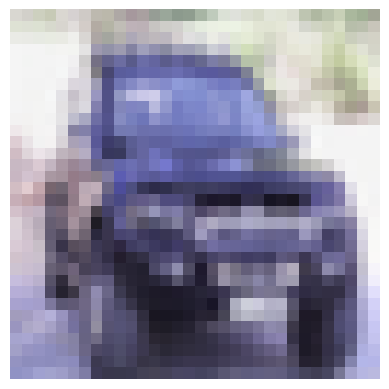

In [24]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

file = 'D:\code\code_xwd\dataset\cifar-10-batches-py\\test_batch'
dict = unpickle(file)

plt.ion()
plt.figure()
plt.axis('off')
plt.xticks([])    # 去 x 轴刻度
plt.yticks([])    # 去 y 轴刻度
for i in range(0, 10):
    image_m = np.reshape(dict.get("data")[i], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    plt.imshow(img32) # cifar10 原图
    plt.savefig(f'D:/code/code_xwd/dataset/cifar-10-batches-py/pic/test/{i}.png',bbox_inches='tight', pad_inches = 0)
plt.show()

In [10]:
image_m = np.reshape(after_dict.get("data")[4999], (3, 32, 32))
r = image_m[0, :, :]
g = image_m[1, :, :]
b = image_m[2, :, :]
img32_after = np.array(cv.merge([r, g, b]))

image_m = np.reshape(before_dict.get("data")[4999], (3, 32, 32))
r = image_m[0, :, :]
g = image_m[1, :, :]
b = image_m[2, :, :]
img32_before = np.array(cv.merge([r, g, b]))

difference = cv.subtract(img32_after, img32_before)
result = not np.any(difference) #if difference is all zeros it will return False

if result is True:
    print("\n两张图片一样")
else:
    cv.imwrite("result.jpg", difference)
    print ("\n两张图片不一样")



两张图片不一样
